In [1]:
import pandas as pd #version 1.1.3
import numpy as np #1.23.2
import matplotlib.pyplot as plt #matplotlib version 3.3.2
import seaborn as sns #0.11.0
import datetime as dt
from datetime import date
import itertools
from dateutil.relativedelta import relativedelta

import statsmodels as sm #version 0.14.1
import statsmodels.api as smt
from statsmodels.tsa.stattools import adfuller

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
# pip install pmdarima --user (for installing pmdarima)
import pmdarima as pm 
from itertools import product

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf #version number 2.9.1
from tensorflow.keras.layers import Dense, LSTM, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import random as python_random

import warnings
warnings.filterwarnings("ignore")

import random
random.seed(42)

import random as python_random
np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)

# Import Data

In [2]:
# CPI data import for modelling

cpi_train = pd.read_csv("CPI_train.csv")
df = cpi_train.copy()
df['Quarter']=pd.to_datetime(df['Quarter'])     
df.set_index('Quarter', inplace=True)                
print(df.head())
print(df.tail())

             CPI
Quarter         
1990-03-01  50.3
1990-06-01  51.7
1990-09-01  51.3
1990-12-01  51.8
1991-03-01  52.9
              CPI
Quarter          
2021-12-01  115.0
2022-03-01  118.2
2022-06-01  120.6
2022-09-01  124.5
2022-12-01  125.6


In [3]:
# Cash Rate data import for qualitative analysis

cash_rate_historical = pd.read_excel("cashrate_data.xlsx", 
                          sheet_name = 'Historical')

cash_rate_outlook = pd.read_excel("cashrate_data.xlsx", 
                          sheet_name = 'Outlook', header = None)

df_historical = cash_rate_historical.copy()
df_outlook = cash_rate_outlook.copy()

# Cash Rate data initial preprocessing

df_outlook = df_outlook.rename({0:'date', 1: 'cashrate'}, axis = 1)
df_historical.columns = df_historical.columns.str.lower()

df_historical['date'] = pd.to_datetime(df_historical['date'])
df_historical.set_index('date', inplace=True)

df_outlook['date'] = pd.to_datetime(df_outlook['date'])
df_outlook.set_index('date', inplace=True)

print(df_historical.head())
print(df_outlook.head())

            cashrate
date                
2011-01-04      4.75
2011-01-05      4.75
2011-01-06      4.75
2011-01-07      4.75
2011-01-10      4.75
            cashrate
date                
2023-01-01      3.10
2023-02-01      3.10
2023-03-01      3.35
2023-04-01      3.60
2023-05-01      3.60


# EDA

### Statistical Overview and Time Plot

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 1990-03-01 to 2022-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CPI     132 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


In [5]:
df.describe()

,CPI
count,132.000000
mean,83.634091
std,21.548397
min,50.300000
25%,62.075000
50%,85.650000
75%,103.800000
max,125.600000


In [6]:
df_historical.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3036 entries, 2011-01-04 to 2022-12-30
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   cashrate  3036 non-null   float64
dtypes: float64(1)
memory usage: 47.4 KB


In [7]:
df_historical.describe()

,cashrate
count,3036.000000
mean,1.942029
std,1.316384
min,0.100000
25%,1.000000
50%,1.500000
75%,2.500000
max,4.750000


In [8]:
df_outlook.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21 entries, 2023-01-01 to 2024-09-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   cashrate  21 non-null     float64
dtypes: float64(1)
memory usage: 336.0 bytes


In [9]:
df_outlook.describe()

,cashrate
count,21.000000
mean,4.028571
std,0.426782
min,3.100000
25%,3.850000
50%,4.100000
75%,4.350000
max,4.350000


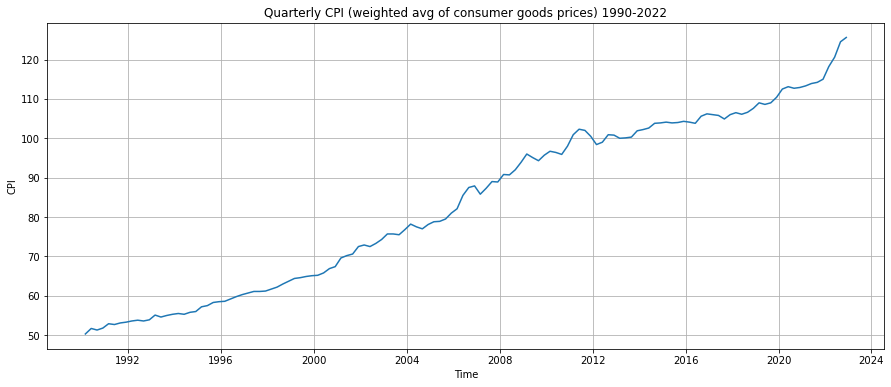

In [10]:
# Extract CPI column
ts = df['CPI']

# create a figure and plot the time series
plt.figure(figsize=(15,6))                          
plt.plot(ts.index, ts)
plt.grid()
plt.title('Quarterly CPI (weighted avg of consumer goods prices) 1990-2022')  
plt.xlabel('Time')                    
plt.ylabel('CPI')    
plt.show()

In [11]:
"""
The format of Cash Rate data is not the same as CPI train data.
While the Cash Rate data is daily data, CPI train data is quarterly. 
So before doing any kind of analysis or comparison between 2 datasets,
they should reflect same format first. Hence, Cash Rate data was converted to quarterly format using group by
functionality
"""

df_historical = df_historical.reset_index()
df_historical['month'] = np.where(df_historical['date'].dt.month.isin([12,1,2]), 
                                    3, 
                                   np.where(df_historical['date'].dt.month.isin([3,4,5]), 
                                    6,
                                   np.where(df_historical['date'].dt.month.isin([6,7,8]), 
                                    9, 
                                   12)))


df_historical['year'] = df_historical['date'].dt.year
df_historical['day'] = 1
df_historical['quarter'] = pd.to_datetime(df_historical[['year','month', 'day']])

df_historical = df_historical.groupby(['quarter']).agg({'cashrate':'mean'})

Text(0.5, 1.0, 'Cashrate vs CPI correlation')

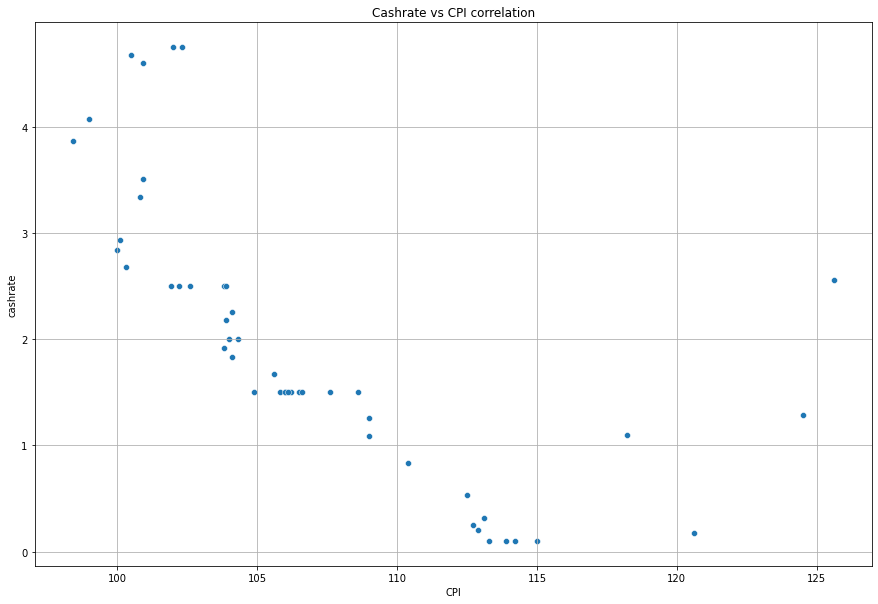

In [12]:
# Plotting possible correlation between CPI and Cash Rate via scatter plot
plt.figure(figsize=(15,10)) 
plt.grid()
sns.scatterplot(df['2011':]['CPI'], df_historical['cashrate'])
plt.title('Cashrate vs CPI correlation')

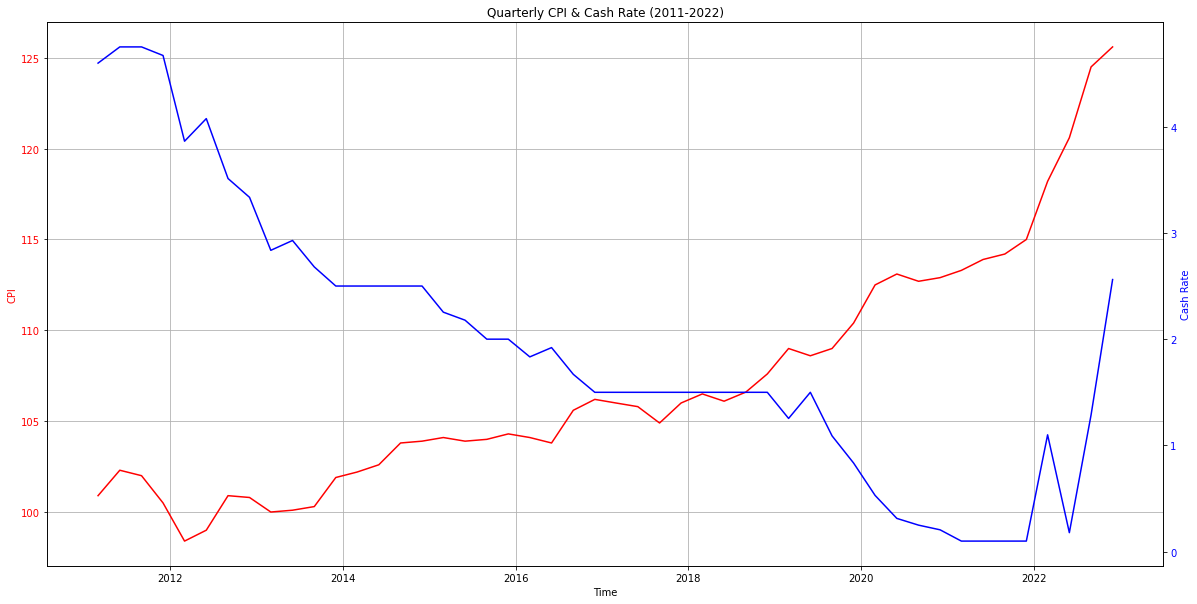

In [13]:
# Plotting 2011-2022 pattern between CPI and Cash Rate since Cash Rate data is available since 2011
ts_cpi = df['2011':]['CPI']
ts_cash = df_historical['cashrate']

fig, ax1 = plt.subplots(figsize=(20, 10))
plt.title('Quarterly CPI & Cash Rate (2011-2022)')
plt.grid()

# CPI
ax1.plot(ts_cpi, color='red', label='CPI')
ax1.set_xlabel('Time')                     
ax1.set_ylabel('CPI', color='red')        
ax1.tick_params(axis='y', labelcolor='red')

# Cash Rate
ax2 = ax1.twinx()                          
ax2.plot(ts_cash, color='blue', label='Cash Rate')
ax2.set_ylabel('Cash Rate', color='blue') 
ax2.tick_params(axis='y', labelcolor='blue')

### Time Series Decomposition

In [14]:
# Window size 4 since we are dealing with quarterly data
ts_CMA4 = ts.rolling(4,center=True).mean().rolling(2,center=True).mean().shift(-1)
ts_CMA4

Quarter
1990-03-01         NaN
1990-06-01         NaN
1990-09-01     51.6000
1990-12-01     52.0500
1991-03-01     52.4000
                ...   
2021-12-01    116.1625
2022-03-01    118.2875
2022-06-01    120.9000
2022-09-01         NaN
2022-12-01         NaN
Name: CPI, Length: 132, dtype: float64

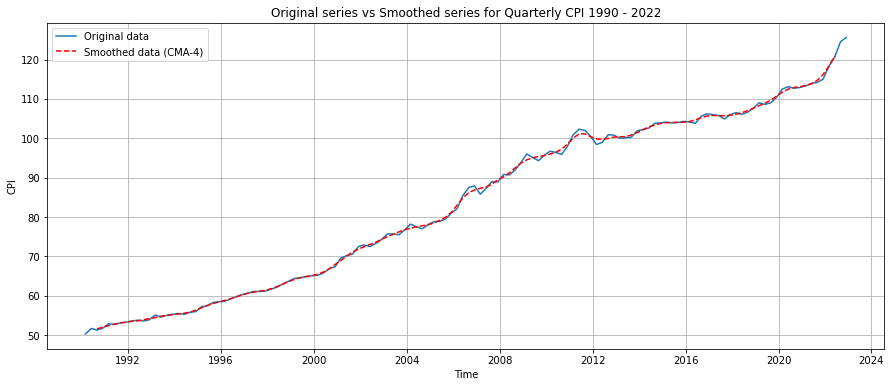

In [15]:
# Plot the original and smooth series
plt.figure(figsize=(15,6))
plt.grid()
plt.plot(ts)
plt.plot(ts_CMA4,'--r')
plt.legend(['Original data','Smoothed data (CMA-4)'])
plt.xlabel('Time')
plt.ylabel('CPI')
plt.title('Original series vs Smoothed series for Quarterly CPI 1990 - 2022')
plt.show()

In [16]:
# obtaining detrended series
ts_res = ts - ts_CMA4
ts_res

Quarter
1990-03-01       NaN
1990-06-01       NaN
1990-09-01   -0.3000
1990-12-01   -0.2500
1991-03-01    0.5000
               ...  
2021-12-01   -1.1625
2022-03-01   -0.0875
2022-06-01   -0.3000
2022-09-01       NaN
2022-12-01       NaN
Name: CPI, Length: 132, dtype: float64

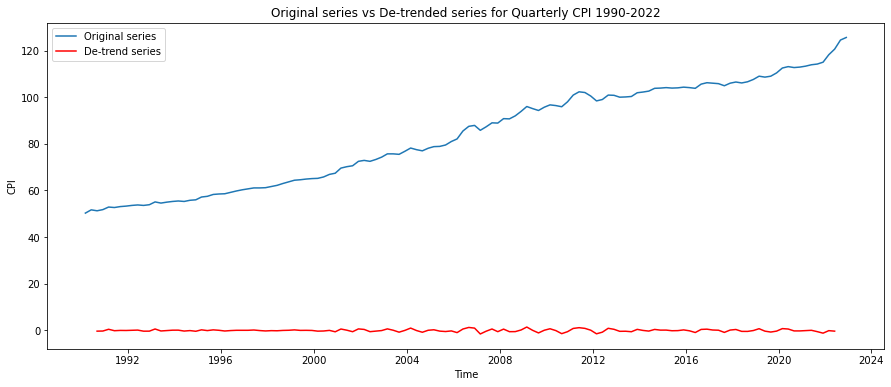

In [17]:
# Plot the de-trended and original series
plt.figure(figsize = (15,6))
plt.plot(ts.index,ts,label="Original series")
plt.plot(ts.index,ts_res,'r-',label="De-trend series")
plt.xlabel('Time')
plt.ylabel('CPI')
plt.legend()
plt.title('Original series vs De-trended series for Quarterly CPI 1990-2022')
plt.show()

In [18]:
# Replace missing values in the ts_res by zeros
ts_res_zero = np.nan_to_num(ts_res)

# Reshape the de-trended series to a table. 
quarterly_S = np.reshape(ts_res_zero, (33, 4))

# Calculate column averages (Average number of passengers in 4 quarters of 33 years)
quarterly_avg = np.mean(quarterly_S[1:32,:], axis=0)

In [19]:
# Normalizing seasonal indexes using additive decomposition method
seasonal_idx = quarterly_avg.mean()
seasonal_idx_normalized = quarterly_avg - seasonal_idx
print(seasonal_idx_normalized.mean())

2.6020852139652106e-18


In [20]:
# Subtract the seasonal average from the original data 
# to obtain the seasonal adjusted data
seasonal = np.tile(seasonal_idx_normalized, 33)
seasonally_adjusted = ts - seasonal

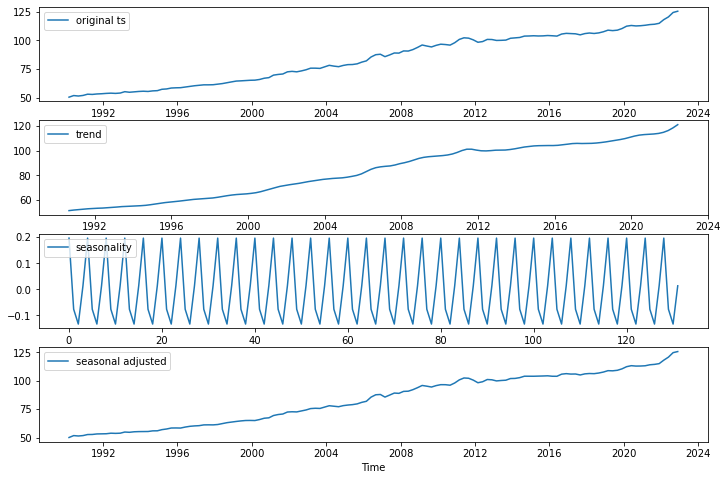

In [21]:
# Plot the original ts, trend, seasonality, and seasonally adjusted data:
fig, ax = plt.subplots(4, 1,figsize=(12,8))
ax[0].plot(ts)
ax[1].plot(ts_CMA4)
ax[2].plot(seasonal)
ax[3].plot(seasonally_adjusted)
ax[0].legend(['original ts'], loc=2)
ax[1].legend(['trend'], loc=2)
ax[2].legend(['seasonality'], loc=2)
ax[3].legend(['seasonal adjusted'], loc=2)
plt.xlabel('Time')
plt.show()

### Lag Analysis

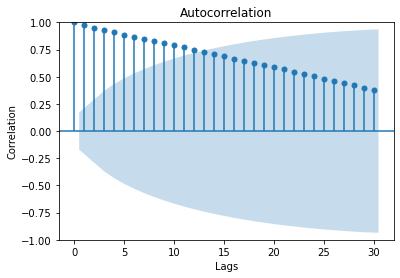

In [22]:
#ACF plot to claim whether given time series is stationary or not stationary
smt.graphics.tsa.plot_acf(ts, lags=30, alpha = 0.05)
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.show()

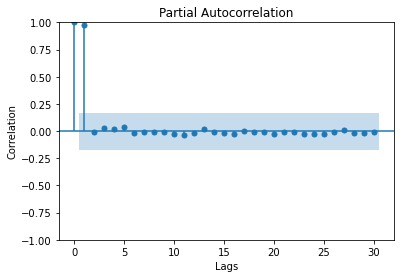

In [23]:
# PACF plot
smt.graphics.tsa.plot_pacf(ts, lags=30, alpha = 0.05)
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.show()

In [24]:
#Formal way to test whether given time series is stationary or not stationary

def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    
    # Print test outputs
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','pvalue','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

def plot_curve(timeseries, window_size):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window_size,center=True).mean()
    rolstd = timeseries.rolling(window_size,center=True).std()

    # Plot rolling statistics:
    plt.figure(figsize=(13,6))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.xlabel('Time')
    plt.ylabel('CPI')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation for Quarterly CPI 1990-2022')
    plt.grid()
    plt.show()

Results of Dickey-Fuller Test:
Test Statistic                   0.948466
pvalue                           0.993691
#Lags Used                       2.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


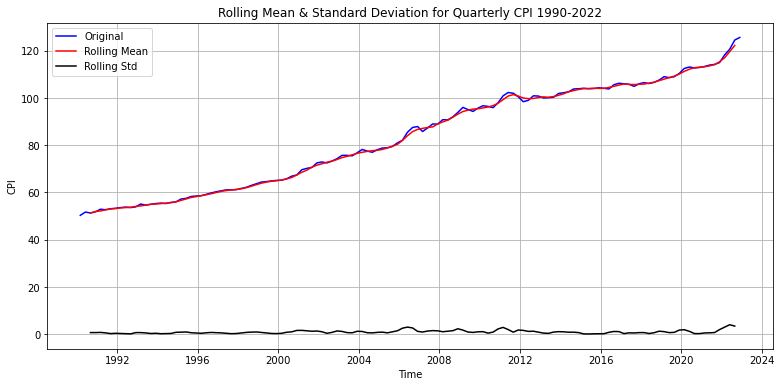

In [25]:
#Function calls
test_stationarity(ts)
plot_curve(ts, window_size = 4)

# Modelling

### In and Out Of Sample Splitting

In [26]:
# in-sample data
df_in = df[:'2021-06']

# below validation and train set are splitted from entire in-sample since some models (ARIMA, FNN)
#require parameter tuning using grid search
train_size = int(len(df_in)*0.8) #it gives 100
val_size = len(df_in) - train_size #it gives 26

df_train = df_in.iloc[:100,:]
df_val = df.iloc[100:,:]

# last 6 values kept as out-of-sample according to forecast horizon where we need to forecast for unseen 6 quarter
df_out = df['2021-09':]

### Linear Regression

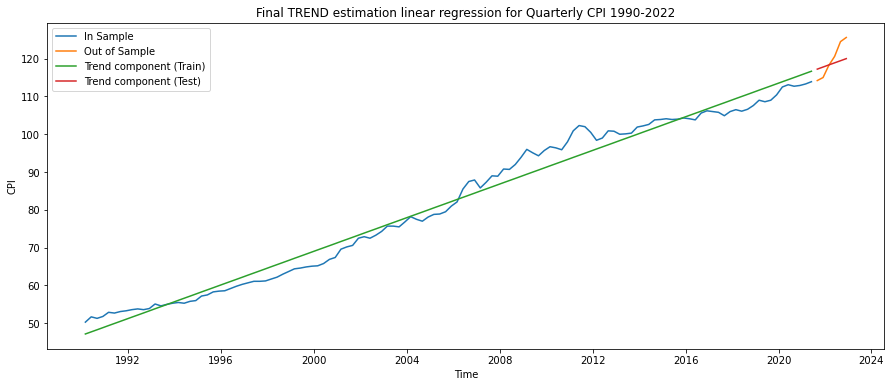

In [27]:
# Prepare training data
# Usually, seasonally adjusted series need to be used for Linear Regression;
# however, since there is no seasonality, in-sample data has been used as is
# do not get confused at naming

seasonally_adjusted_train = df_in
seasonally_adjusted_test = df_out

X = np.linspace(1, len(seasonally_adjusted_train), len(seasonally_adjusted_train)) # Create time indexes from 1 to T as the input
X = np.reshape(X, (len(seasonally_adjusted_train), 1))                       # Transform X to 2D array (matrix)
y = seasonally_adjusted_train.values    

# Create a LinearRegression object
lm = LinearRegression()   

# Train the linear regression model on training data (X,y)
lm.fit(X, y)

#fitting in-sample data
trend_linear_train = lm.predict(X)
trend_linear_test = lm.predict(len(seasonally_adjusted_train) + np.reshape(np.arange(len(seasonally_adjusted) - len(seasonally_adjusted_train))+1, 
                                          (len(seasonally_adjusted) - len(seasonally_adjusted_train), 1)))

# Now plot the seasonally adjusted data and the corresponding regression line
plt.figure(figsize=(15,6))

plt.plot(seasonally_adjusted_train)
plt.plot(seasonally_adjusted_test)

plt.plot(seasonally_adjusted_train.index, trend_linear_train)
plt.plot(seasonally_adjusted_test.index, trend_linear_test)

plt.title('Final TREND estimation linear regression for Quarterly CPI 1990-2022')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.legend(['In Sample', 'Out of Sample', 'Trend component (Train)', 'Trend component (Test)'])
plt.show()

### TCES and Damped TCES

In [28]:
# Damped TCES
fit_damped_trend = ExponentialSmoothing(df_in, damped_trend = True, trend='add').fit()
# TCES
fit_trend = ExponentialSmoothing(df_in, damped_trend = False, trend='add').fit() 

In [29]:
# symbol r $ and \ in the results variable are the latex symbols for visualization in notebook
results = pd.DataFrame(index=[r"$\alpha$",\
                              r"$\beta$",\
                              r"$\gamma$",\
                              r"$l_0$",\
                              "$b_0$",\
                              "SSE"])
# ExponentialSmoothing() object has following attributes
params = ['smoothing_level', \
          'smoothing_trend', \
          'smoothing_seasonal', \
          'initial_level', \
          'initial_trend']

# check out the performance of trend and damped trend
results["Damped Trend"]       = [fit_damped_trend.params[p] for p in params] + [fit_damped_trend.sse]
results["Trend"] = [fit_trend.params[p] for p in params] + [fit_trend.sse]
print(results)

          Damped Trend         Trend
$\alpha$  1.000000e+00  1.000000e+00
$\beta$   7.012669e-12  2.255528e-13
$\gamma$           NaN           NaN
$l_0$     4.963844e+01  4.979120e+01
$b_0$     6.648825e-01  5.088001e-01
SSE       9.706829e+01  9.574032e+01


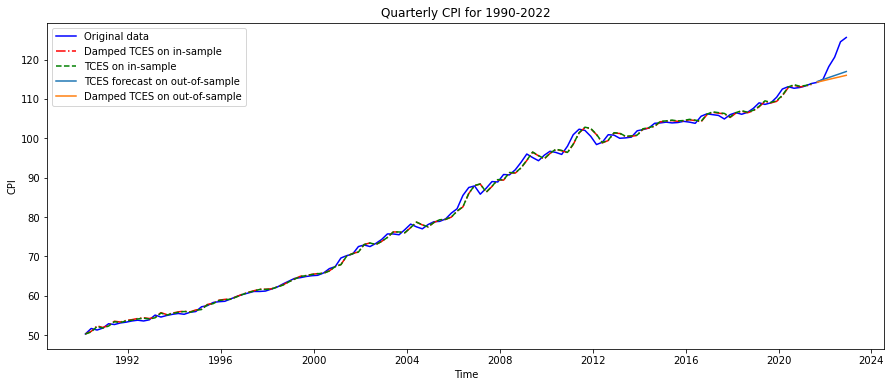

In [30]:
# Obtain fitted values from the fittedvalues attribute
fit_damped_trend_train = fit_damped_trend.fittedvalues
fit_trend_train = fit_trend.fittedvalues

y_forecast_trend = fit_trend.forecast(len(df_out))
y_forecast_damped_trend = fit_damped_trend.forecast(len(df_out))


# Plot all together
plt.figure(figsize=(15,6))
plt.plot(df, 'b-', label = 'Original data') 
plt.plot(fit_damped_trend_train, 'r-.',label = 'Damped TCES on in-sample')
plt.plot(fit_trend_train, 'g--', label = 'TCES on in-sample')
plt.plot(y_forecast_trend, label = 'TCES forecast on out-of-sample')
plt.plot(y_forecast_damped_trend, label = 'Damped TCES on out-of-sample')
plt.xlabel("Time")
plt.ylabel("CPI")
plt.title("Quarterly CPI for 1990-2022")
plt.legend()
plt.show()

## ARIMA

In [31]:
# differencing for getting stationary time series
ts_diff = pd.Series.diff(df_in['CPI'])

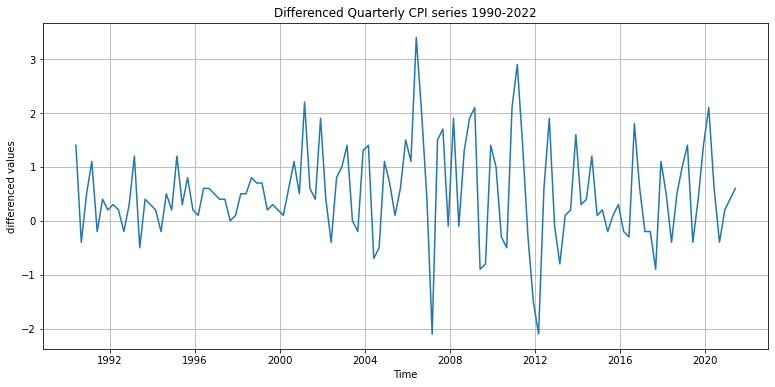

In [32]:
# Discard the nan value
ts_diff = ts_diff.dropna()

# Plot the differenced data
plt.figure(figsize=(13,6))
plt.plot(ts_diff)
plt.xlabel('Time')
plt.ylabel('differenced values')
plt.title('Differenced Quarterly CPI series 1990-2022')
plt.grid()
plt.show()

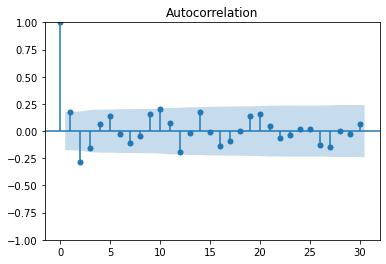

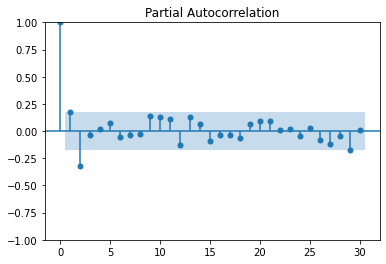

In [33]:
# Sample ACF
smt.graphics.tsa.plot_acf(ts_diff, lags=30, alpha = 0.05)
plt.show()

# Sample PACF
smt.graphics.tsa.plot_pacf(ts_diff, lags=30, alpha = 0.05)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -9.892273e+00
pvalue                         3.532135e-17
#Lags Used                     1.000000e+00
Number of Observations Used    1.230000e+02
Critical Value (1%)           -3.484667e+00
Critical Value (5%)           -2.885340e+00
Critical Value (10%)          -2.579463e+00
dtype: float64


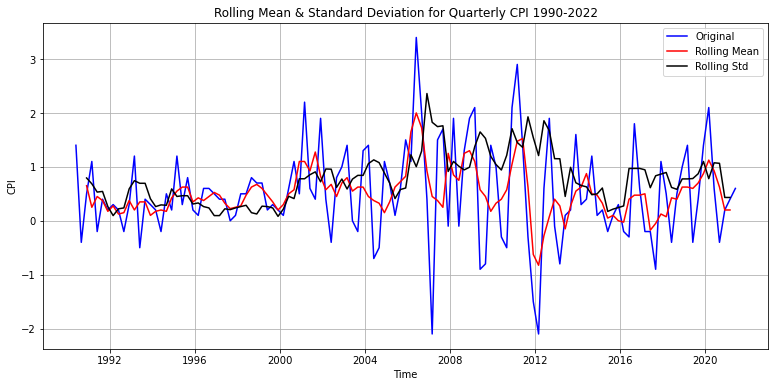

In [34]:
# Call test_stationarity() function to perform Dickey-Fuller test for the original series
test_stationarity(ts_diff)   

# Then call the plot_curve() to visualize the original, rolling mean and rolling std series
plot_curve(ts_diff, 4)

In [35]:
# defining parameter set for grid search for ARIMA

p = range(0, 4)  # Try p values from 0 to 5
q = range(0, 4)  # Try q values from 0 to 5
d = range(1, 2)  # since we already did differencing, we do not add range here for d, only default value = 1

# Create all combinations of p, d, q
pdq = list(itertools.product(p, d, q))

# Initialize variables to store the best parameters and the corresponding test error
best_order = None
best_error = float("inf")

def test_error(y_test, y_pred):
    """ Calculate the test error based on provided logic """
    if isinstance(y_pred, pd.Series):
        error = sum((y_test - y_pred)**2) / len(y_test)  # Mean squared error
    else:
        error = sum((y_test.values - pd.Series(y_pred.ravel()))**2) / len(y_test)  # Adjust if y_pred is not a Series
    return error 

# Iterate over all possible combinations of p, d, q
for param in pdq:
    
    # Fit the ARIMA model with the current parameters on the training set
    model = ARIMA(df_train['CPI'], order = param)
    model_fit = model.fit()

    # Generate predictions for the validation set
    y_pred = model_fit.forecast(steps=len(df_val))

    # Calculate test error
    error = test_error(df_val['CPI'], y_pred)

    # Check if the current model has the lowest test error
    if error < best_error:
        best_order = param
        best_error = error

    print(f"ARIMA - {param} - Test Error: {error}")

# Output the best p, d, q combination and its corresponding test error
print(f"Best ARIMA order: {best_order} with Test Error: {best_error}")

ARIMA - (0, 1, 0) - Test Error: 71.37937499999992
ARIMA - (0, 1, 1) - Test Error: 73.2069189415194
ARIMA - (0, 1, 2) - Test Error: 73.23038799968884
ARIMA - (0, 1, 3) - Test Error: 72.97421348553374
ARIMA - (1, 1, 0) - Test Error: 70.61561350171228
ARIMA - (1, 1, 1) - Test Error: 73.22424225139618
ARIMA - (1, 1, 2) - Test Error: 10.684455837439563
ARIMA - (1, 1, 3) - Test Error: 9.051328828233567
ARIMA - (2, 1, 0) - Test Error: 73.49867176926108
ARIMA - (2, 1, 1) - Test Error: 72.87433710716333
ARIMA - (2, 1, 2) - Test Error: 11.23471288659169
ARIMA - (2, 1, 3) - Test Error: 19.044044544989454
ARIMA - (3, 1, 0) - Test Error: 68.89200896753887
ARIMA - (3, 1, 1) - Test Error: 8.99033181937955
ARIMA - (3, 1, 2) - Test Error: 8.608431897135889
ARIMA - (3, 1, 3) - Test Error: 12.348597883186688
Best ARIMA order: (3, 1, 2) with Test Error: 8.608431897135889


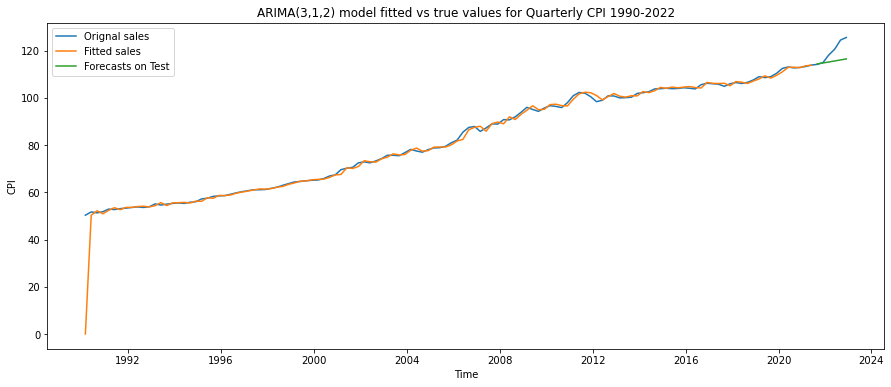

In [36]:
#Refitting with the best parameters
p, d, q = best_order[0], 1, best_order[2]

model_AIC = ARIMA(df_in, order=(p, d, q))
results_AIC_ARIMA = model_AIC.fit()

# Get Fitted Series
fitted_AIC = results_AIC_ARIMA.predict()

# Get forecasts on test set
y_forecast_ARIMA = results_AIC_ARIMA.predict(start = len(df_in), end = len(df_in) + len(df_out)-1)

# Actual vs Fitted
plt.figure(figsize=(15,6))
plt.plot(df,label='Orignal sales')
plt.plot(fitted_AIC,label='Fitted sales')
plt.plot(y_forecast_ARIMA, label='Forecasts on Test')
plt.title(f"ARIMA({p},{d},{q}) model fitted vs true values for Quarterly CPI 1990-2022")
plt.xlabel('Time')
plt.ylabel('CPI')
plt.legend(loc=2)
plt.show()

# FNN

In [37]:
# defining parameter set for grid search
time_window_range = [4,6]
epochs_range = [300]
batch_size_range = [20, 30]

best_mse = float('inf')  # Start with a high MSE
best_params = None

# Iterate through all combinations
for time_window, epochs, batch_size in product(time_window_range, epochs_range, batch_size_range):

    scaler = MinMaxScaler(feature_range=(0, 1))
    
    # defining train_size
    train_size = int(len(df_train) - time_window)
    
    # Fitting the scaler
    fitted_transformer = scaler.fit(df_train[:train_size + time_window])

    # Transforming using trained scaler
    data_scaled = fitted_transformer.transform(df_in)

    # Pre-allocation
    Xall, Yall = [], []
    Xall_not_scaled, Yall_not_scaled = [], []

    data_not_scaled = np.array(df_in['CPI']).reshape(len(df_in),1)

    # Use each rolling window as a row in the data matrix 
    for i in range(time_window, len(data_scaled)):
        Xall.append(data_scaled[i-time_window:i, 0]) # Access the accuracy
        Xall_not_scaled.append(data_not_scaled[i-time_window:i, 0]) # Training NN
        Yall.append(data_scaled[i, 0])
        Yall_not_scaled.append(data_not_scaled[i, 0])

    # Convert them from list to numpy array
    Xall = np.array(Xall)
    Yall = np.array(Yall)
    Xall_not_scaled = np.array(Xall_not_scaled)
    Yall_not_scaled = np.array(Yall_not_scaled)

    # Training data
    Xtrain = Xall[:train_size, :]
    Ytrain = Yall[:train_size]

    test_size = len(df_val)

    # Test data
    Xtest = Xall[-test_size:, :]
    Ytest = Yall[-test_size:]

    model = Sequential()
    model.add(Dense(10, input_dim = time_window, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    model.fit(Xtrain, Ytrain, epochs=epochs, batch_size=batch_size , verbose=1)

    # In-sample and out of sample forecast 
    allPredict = model.predict(Xall)

    # Transform the forecast values to original scale
    allPredictPlot = scaler.inverse_transform(allPredict)

    # Extract in-sample forecast in original scale
    Predict_in = allPredictPlot[:train_size]

    # Extract out-of-sample forecast in original scale
    Predict_out = allPredictPlot[-test_size:]

    trainScore_not_scaled_train = mean_squared_error(Yall_not_scaled[:train_size], allPredictPlot[:train_size,0])
    print('Training Data MSE on original scale: {0:.2f}'.format(trainScore_not_scaled_train))

    testScore_not_scaled_test = mean_squared_error(Yall_not_scaled[train_size:], allPredictPlot[train_size:,0])
    print('Test Data MSE original scale: {0:.2f}'.format(testScore_not_scaled_test))
    
    if testScore_not_scaled_test < best_mse:
        best_mse = testScore_not_scaled_test
        best_params = (time_window, epochs, batch_size)

# Output the best parameters found
print(f'Best Parameters: Time Window = {best_params[0]}, Epochs = {best_params[1]}, Batch Size = {best_params[2]}')
print(f'Best Test MSE: {best_mse:.2f}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
5/5 [==============================] - 1s 4ms/step - loss: 0.3899
Epoch 2/300
5/5 [==============================] - 0s 3ms/step - loss: 0.3372
Epoch 3/300
5/5 [==============================] - 0s 3ms/step - loss: 0.2897
Epoch 4/300
5/5 [==============================] - 0s 4ms/step - loss: 0.2471
Epoch 5/300
5/5 [==============================] - 0s 2ms/step - loss: 0.2080
Epoch 6/300
5/5 [==============================] - 0s 3ms/step - l

5/5 [==============================] - 0s 3ms/step - loss: 8.6990e-04
Epoch 96/300
5/5 [==============================] - 0s 1ms/step - loss: 8.5227e-04
Epoch 97/300
5/5 [==============================] - 0s 1ms/step - loss: 8.3708e-04
Epoch 98/300
5/5 [==============================] - 0s 1ms/step - loss: 8.2158e-04
Epoch 99/300
5/5 [==============================] - 0s 4ms/step - loss: 8.0694e-04
Epoch 100/300
5/5 [==============================] - 0s 4ms/step - loss: 7.9487e-04
Epoch 101/300
5/5 [==============================] - 0s 3ms/step - loss: 7.8381e-04
Epoch 102/300
5/5 [==============================] - 0s 3ms/step - loss: 7.7130e-04
Epoch 103/300
5/5 [==============================] - 0s 2ms/step - loss: 7.5963e-04
Epoch 104/300
5/5 [==============================] - 0s 3ms/step - loss: 7.4996e-04
Epoch 105/300
5/5 [==============================] - 0s 4ms/step - loss: 7.4036e-04
Epoch 106/300
5/5 [==============================] - 0s 3ms/step - loss: 7.3134e-04
Epoch 107/

5/5 [==============================] - 0s 2ms/step - loss: 6.1517e-04
Epoch 193/300
5/5 [==============================] - 0s 3ms/step - loss: 6.1493e-04
Epoch 194/300
5/5 [==============================] - 0s 3ms/step - loss: 6.1433e-04
Epoch 195/300
5/5 [==============================] - 0s 2ms/step - loss: 6.1379e-04
Epoch 196/300
5/5 [==============================] - 0s 3ms/step - loss: 6.1444e-04
Epoch 197/300
5/5 [==============================] - 0s 4ms/step - loss: 6.1469e-04
Epoch 198/300
5/5 [==============================] - 0s 4ms/step - loss: 6.1577e-04
Epoch 199/300
5/5 [==============================] - 0s 3ms/step - loss: 6.1315e-04
Epoch 200/300
5/5 [==============================] - 0s 4ms/step - loss: 6.1379e-04
Epoch 201/300
5/5 [==============================] - 0s 4ms/step - loss: 6.1490e-04
Epoch 202/300
5/5 [==============================] - 0s 2ms/step - loss: 6.1333e-04
Epoch 203/300
5/5 [==============================] - 0s 3ms/step - loss: 6.1325e-04
Epoch 

5/5 [==============================] - 0s 3ms/step - loss: 6.0339e-04
Epoch 290/300
5/5 [==============================] - 0s 3ms/step - loss: 6.0273e-04
Epoch 291/300
5/5 [==============================] - 0s 3ms/step - loss: 6.0337e-04
Epoch 292/300
5/5 [==============================] - 0s 3ms/step - loss: 6.0181e-04
Epoch 293/300
5/5 [==============================] - 0s 2ms/step - loss: 6.0204e-04
Epoch 294/300
5/5 [==============================] - 0s 4ms/step - loss: 6.0181e-04
Epoch 295/300
5/5 [==============================] - 0s 3ms/step - loss: 6.0152e-04
Epoch 296/300
5/5 [==============================] - 0s 4ms/step - loss: 6.0230e-04
Epoch 297/300
5/5 [==============================] - 0s 3ms/step - loss: 6.0272e-04
Epoch 298/300
5/5 [==============================] - 0s 4ms/step - loss: 6.0152e-04
Epoch 299/300
5/5 [==============================] - 0s 4ms/step - loss: 6.0069e-04
Epoch 300/300
4/4 [==============================] - 0s 3ms/step
Training Data MSE on orig

4/4 [==============================] - 0s 5ms/step - loss: 5.2181e-04
Epoch 79/300
4/4 [==============================] - 0s 4ms/step - loss: 5.0641e-04
Epoch 80/300
4/4 [==============================] - 0s 4ms/step - loss: 5.0351e-04
Epoch 81/300
4/4 [==============================] - 0s 5ms/step - loss: 5.2393e-04
Epoch 82/300
4/4 [==============================] - 0s 5ms/step - loss: 5.2573e-04
Epoch 83/300
4/4 [==============================] - 0s 4ms/step - loss: 5.1351e-04
Epoch 84/300
4/4 [==============================] - 0s 4ms/step - loss: 5.1079e-04
Epoch 85/300
4/4 [==============================] - 0s 5ms/step - loss: 5.0843e-04
Epoch 86/300
4/4 [==============================] - 0s 5ms/step - loss: 5.0713e-04
Epoch 87/300
4/4 [==============================] - 0s 5ms/step - loss: 5.0183e-04
Epoch 88/300
4/4 [==============================] - 0s 4ms/step - loss: 5.0674e-04
Epoch 89/300
4/4 [==============================] - 0s 4ms/step - loss: 5.1785e-04
Epoch 90/300
4/4 

Epoch 176/300
4/4 [==============================] - 0s 3ms/step - loss: 4.8832e-04
Epoch 177/300
4/4 [==============================] - 0s 3ms/step - loss: 4.9159e-04
Epoch 178/300
4/4 [==============================] - 0s 3ms/step - loss: 4.9069e-04
Epoch 179/300
4/4 [==============================] - 0s 3ms/step - loss: 4.9168e-04
Epoch 180/300
4/4 [==============================] - 0s 3ms/step - loss: 4.9334e-04
Epoch 181/300
4/4 [==============================] - 0s 2ms/step - loss: 4.9298e-04
Epoch 182/300
4/4 [==============================] - 0s 3ms/step - loss: 4.9012e-04
Epoch 183/300
4/4 [==============================] - 0s 4ms/step - loss: 4.8842e-04
Epoch 184/300
4/4 [==============================] - 0s 4ms/step - loss: 4.9052e-04
Epoch 185/300
4/4 [==============================] - 0s 4ms/step - loss: 4.8562e-04
Epoch 186/300
4/4 [==============================] - 0s 6ms/step - loss: 4.8709e-04
Epoch 187/300
4/4 [==============================] - 0s 5ms/step - loss: 4.8

4/4 [==============================] - 0s 3ms/step - loss: 4.6857e-04
Epoch 274/300
4/4 [==============================] - 0s 3ms/step - loss: 4.6985e-04
Epoch 275/300
4/4 [==============================] - 0s 3ms/step - loss: 4.7390e-04
Epoch 276/300
4/4 [==============================] - 0s 3ms/step - loss: 4.7041e-04
Epoch 277/300
4/4 [==============================] - 0s 3ms/step - loss: 4.6899e-04
Epoch 278/300
4/4 [==============================] - 0s 3ms/step - loss: 4.6867e-04
Epoch 279/300
4/4 [==============================] - 0s 3ms/step - loss: 4.6829e-04
Epoch 280/300
4/4 [==============================] - 0s 3ms/step - loss: 4.6641e-04
Epoch 281/300
4/4 [==============================] - 0s 3ms/step - loss: 4.6853e-04
Epoch 282/300
4/4 [==============================] - 0s 4ms/step - loss: 4.6594e-04
Epoch 283/300
4/4 [==============================] - 0s 4ms/step - loss: 4.6601e-04
Epoch 284/300
4/4 [==============================] - 0s 3ms/step - loss: 4.7394e-04
Epoch 

5/5 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 66/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 67/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 68/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 69/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 70/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 71/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 72/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0010
Epoch 73/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0010
Epoch 74/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0010
Epoch 75/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 76/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 77/300
5/5 [==============================] - 0s 4ms/step -

5/5 [==============================] - 0s 3ms/step - loss: 9.6818e-04
Epoch 167/300
5/5 [==============================] - 0s 3ms/step - loss: 9.7055e-04
Epoch 168/300
5/5 [==============================] - 0s 3ms/step - loss: 9.7895e-04
Epoch 169/300
5/5 [==============================] - 0s 4ms/step - loss: 9.6288e-04
Epoch 170/300
5/5 [==============================] - 0s 4ms/step - loss: 9.6875e-04
Epoch 171/300
5/5 [==============================] - 0s 4ms/step - loss: 9.6501e-04
Epoch 172/300
5/5 [==============================] - 0s 3ms/step - loss: 9.6383e-04
Epoch 173/300
5/5 [==============================] - 0s 4ms/step - loss: 9.6333e-04
Epoch 174/300
5/5 [==============================] - 0s 3ms/step - loss: 9.5974e-04
Epoch 175/300
5/5 [==============================] - 0s 5ms/step - loss: 9.5843e-04
Epoch 176/300
5/5 [==============================] - 0s 2ms/step - loss: 9.5314e-04
Epoch 177/300
5/5 [==============================] - 0s 3ms/step - loss: 9.8229e-04
Epoch 

5/5 [==============================] - 0s 3ms/step - loss: 8.7820e-04
Epoch 264/300
5/5 [==============================] - 0s 3ms/step - loss: 8.7587e-04
Epoch 265/300
5/5 [==============================] - 0s 3ms/step - loss: 8.7321e-04
Epoch 266/300
5/5 [==============================] - 0s 3ms/step - loss: 8.8208e-04
Epoch 267/300
5/5 [==============================] - 0s 2ms/step - loss: 8.7590e-04
Epoch 268/300
5/5 [==============================] - 0s 2ms/step - loss: 8.7014e-04
Epoch 269/300
5/5 [==============================] - 0s 3ms/step - loss: 8.7045e-04
Epoch 270/300
5/5 [==============================] - 0s 3ms/step - loss: 8.6749e-04
Epoch 271/300
5/5 [==============================] - 0s 4ms/step - loss: 8.8322e-04
Epoch 272/300
5/5 [==============================] - 0s 3ms/step - loss: 8.9628e-04
Epoch 273/300
5/5 [==============================] - 0s 4ms/step - loss: 8.9816e-04
Epoch 274/300
5/5 [==============================] - 0s 3ms/step - loss: 8.8028e-04
Epoch 

4/4 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 55/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 56/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 57/300
4/4 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 58/300
4/4 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 59/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 60/300
4/4 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 61/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 62/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 63/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 64/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 65/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 66/300
4/4 [==============================] - 0s 3ms/step -

4/4 [==============================] - 0s 3ms/step - loss: 9.3059e-04
Epoch 156/300
4/4 [==============================] - 0s 3ms/step - loss: 9.3240e-04
Epoch 157/300
4/4 [==============================] - 0s 2ms/step - loss: 9.3100e-04
Epoch 158/300
4/4 [==============================] - 0s 2ms/step - loss: 9.2834e-04
Epoch 159/300
4/4 [==============================] - 0s 3ms/step - loss: 9.2858e-04
Epoch 160/300
4/4 [==============================] - 0s 2ms/step - loss: 9.2772e-04
Epoch 161/300
4/4 [==============================] - 0s 3ms/step - loss: 9.2734e-04
Epoch 162/300
4/4 [==============================] - 0s 4ms/step - loss: 9.2632e-04
Epoch 163/300
4/4 [==============================] - 0s 3ms/step - loss: 9.3682e-04
Epoch 164/300
4/4 [==============================] - 0s 5ms/step - loss: 9.3115e-04
Epoch 165/300
4/4 [==============================] - 0s 4ms/step - loss: 9.2842e-04
Epoch 166/300
4/4 [==============================] - 0s 4ms/step - loss: 9.2581e-04
Epoch 

4/4 [==============================] - 0s 668us/step - loss: 9.0105e-04
Epoch 253/300
4/4 [==============================] - 0s 2ms/step - loss: 8.9876e-04
Epoch 254/300
4/4 [==============================] - 0s 3ms/step - loss: 8.9546e-04
Epoch 255/300
4/4 [==============================] - 0s 3ms/step - loss: 8.9390e-04
Epoch 256/300
4/4 [==============================] - 0s 3ms/step - loss: 8.9258e-04
Epoch 257/300
4/4 [==============================] - 0s 2ms/step - loss: 8.9141e-04
Epoch 258/300
4/4 [==============================] - 0s 3ms/step - loss: 8.9143e-04
Epoch 259/300
4/4 [==============================] - 0s 3ms/step - loss: 8.9316e-04
Epoch 260/300
4/4 [==============================] - 0s 4ms/step - loss: 8.9280e-04
Epoch 261/300
4/4 [==============================] - 0s 3ms/step - loss: 8.8943e-04
Epoch 262/300
4/4 [==============================] - 0s 4ms/step - loss: 8.8858e-04
Epoch 263/300
4/4 [==============================] - 0s 3ms/step - loss: 8.9182e-04
Epoc

In [38]:
#Refitting with best parameters

time_window = best_params[0]
epochs = best_params[1]
batch_size = best_params[2]

# Define a scaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# Compute in-sample and out-of-sample size
train_size = int(len(df_in) - time_window)
#test_size = len(df_train) - train_size - time_window

# Fitting the scaler
fitted_transformer = scaler.fit(df_in[:train_size + time_window])

# Transforming using trained scaler
data_scaled = fitted_transformer.transform(df)

print(len(data_scaled) == len(data_not_scaled))

# Pre-allocation
Xall, Yall = [], []
Xall_not_scaled, Yall_not_scaled = [], []

data_not_scaled = np.array(df['CPI']).reshape(len(df),1)

# Use each rolling window as a row in the data matrix 
for i in range(time_window, len(data_scaled)):
    Xall.append(data_scaled[i-time_window:i, 0]) # Access the accuracy
    Xall_not_scaled.append(data_not_scaled[i-time_window:i, 0]) # Training NN
    Yall.append(data_scaled[i, 0])
    Yall_not_scaled.append(data_not_scaled[i, 0])

# Convert them from list to numpy array
Xall = np.array(Xall)
Yall = np.array(Yall)
Xall_not_scaled = np.array(Xall_not_scaled)
Yall_not_scaled = np.array(Yall_not_scaled)

# Training data
Xtrain = Xall[:train_size, :]
Ytrain = Yall[:train_size]

test_size = len(df_out)

# Test data
Xtest = Xall[-test_size:, :]
Ytest = Yall[-test_size:]

model_fnn = Sequential()
model_fnn.add(Dense(10, input_dim = time_window, activation='relu'))
model_fnn.add(Dense(1))
model_fnn.compile(loss='mean_squared_error', optimizer='adam')
model_fnn.summary()
model_fnn.fit(Xtrain, Ytrain, epochs=epochs, batch_size=batch_size , verbose=1)

# In-sample and out of sample forecast 
allPredict = model_fnn.predict(Xall)

# Transform the forecast values to original scale
allPredictPlot = scaler.inverse_transform(allPredict)

# Extract in-sample forecast in original scale
Predict_in = allPredictPlot[:train_size]

# Extract out-of-sample forecast in original scale
Predict_out = allPredictPlot[-test_size:]

trainScore_not_scaled_train = mean_squared_error(Yall_not_scaled[:train_size], allPredictPlot[:train_size,0])
print('Training Data MSE on original scale: {0:.2f}'.format(trainScore_not_scaled_train))

testScore_not_scaled_test = mean_squared_error(Yall_not_scaled[train_size:], allPredictPlot[train_size:,0])
print('Test Data MSE original scale: {0:.2f}'.format(testScore_not_scaled_test))
    

False
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 10)                50        
                                                                 
 dense_9 (Dense)             (None, 1)                 11        
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
5/5 [==============================] - 1s 4ms/step - loss: 0.3801
Epoch 2/300
5/5 [==============================] - 0s 3ms/step - loss: 0.3604
Epoch 3/300
5/5 [==============================] - 0s 3ms/step - loss: 0.3413
Epoch 4/300
5/5 [==============================] - 0s 3ms/step - loss: 0.3225
Epoch 5/300
5/5 [==============================] - 0s 2ms/step - loss: 0.3028
Epoch 6/300
5/5 [==============================] - 0s 3ms/

5/5 [==============================] - 0s 4ms/step - loss: 0.0051
Epoch 97/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 98/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0048
Epoch 99/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0047
Epoch 100/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 101/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0044
Epoch 102/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0043
Epoch 103/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 104/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 105/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0040
Epoch 106/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 107/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 108/300
5/5 [==============================] - 0s 2

5/5 [==============================] - 0s 3ms/step - loss: 4.0474e-04
Epoch 197/300
5/5 [==============================] - 0s 3ms/step - loss: 4.0043e-04
Epoch 198/300
5/5 [==============================] - 0s 3ms/step - loss: 3.9720e-04
Epoch 199/300
5/5 [==============================] - 0s 3ms/step - loss: 3.9711e-04
Epoch 200/300
5/5 [==============================] - 0s 3ms/step - loss: 3.9296e-04
Epoch 201/300
5/5 [==============================] - 0s 3ms/step - loss: 3.9024e-04
Epoch 202/300
5/5 [==============================] - 0s 3ms/step - loss: 3.8658e-04
Epoch 203/300
5/5 [==============================] - 0s 3ms/step - loss: 3.8360e-04
Epoch 204/300
5/5 [==============================] - 0s 3ms/step - loss: 3.8028e-04
Epoch 205/300
5/5 [==============================] - 0s 4ms/step - loss: 3.7834e-04
Epoch 206/300
5/5 [==============================] - 0s 4ms/step - loss: 3.7560e-04
Epoch 207/300
5/5 [==============================] - 0s 4ms/step - loss: 3.7339e-04
Epoch 

5/5 [==============================] - 0s 4ms/step - loss: 3.3021e-04
Epoch 294/300
5/5 [==============================] - 0s 4ms/step - loss: 3.3042e-04
Epoch 295/300
5/5 [==============================] - 0s 3ms/step - loss: 3.3254e-04
Epoch 296/300
5/5 [==============================] - 0s 3ms/step - loss: 3.3435e-04
Epoch 297/300
5/5 [==============================] - 0s 3ms/step - loss: 3.3524e-04
Epoch 298/300
5/5 [==============================] - 0s 3ms/step - loss: 3.3452e-04
Epoch 299/300
5/5 [==============================] - 0s 3ms/step - loss: 3.3213e-04
Epoch 300/300
4/4 [==============================] - 0s 4ms/step
Training Data MSE on original scale: 1.33
Test Data MSE original scale: 11.25


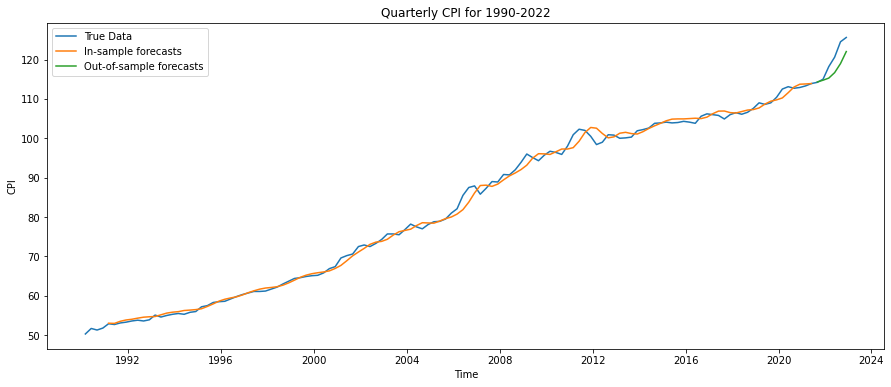

In [39]:
# Plot true and in-sample forecast values
plt.figure(figsize=(15,6))
plt.plot(df.index, scaler.inverse_transform(data_scaled), label='True Data')
plt.plot(df.index[-(train_size+test_size):-test_size],Predict_in, label='In-sample forecasts')
plt.plot(df.index[-test_size:],Predict_out, label='Out-of-sample forecasts')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.title('Quarterly CPI for 1990-2022')
plt.legend()
plt.show()


# LSTM

In [40]:
#defining LSTM model
early_stop = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
Xtrain_lstm = np.reshape(Xtrain, (Xtrain.shape[0], time_window, 1))
Xtest_lstm = np.reshape(Xtest, (Xtest.shape[0], time_window, 1))


model_lstm = Sequential()
model_lstm.add(LSTM(units=8, input_shape = (time_window, 1))) 
model_lstm.add(Dense(units=1))
model_lstm.compile(loss="mean_squared_error", optimizer="adam")
model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 320       
                                                                 
 dense_10 (Dense)            (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [41]:
# fitting to train data
model_lstm.fit(Xtrain_lstm, Ytrain, 
          batch_size = 5,             
          epochs = 300,               
          validation_split = 0.1, 
          shuffle = False,
          verbose = 1, 
          callbacks = [early_stop])

Epoch 1/300
22/22 [==============================] - 5s 62ms/step - loss: 0.2478 - val_loss: 0.6820
Epoch 2/300
22/22 [==============================] - 0s 8ms/step - loss: 0.1481 - val_loss: 0.4454
Epoch 3/300
22/22 [==============================] - 0s 10ms/step - loss: 0.0822 - val_loss: 0.2657
Epoch 4/300
22/22 [==============================] - 0s 11ms/step - loss: 0.0442 - val_loss: 0.1447
Epoch 5/300
22/22 [==============================] - 0s 10ms/step - loss: 0.0291 - val_loss: 0.0786
Epoch 6/300
22/22 [==============================] - 0s 10ms/step - loss: 0.0255 - val_loss: 0.0493
Epoch 7/300
22/22 [==============================] - 0s 9ms/step - loss: 0.0236 - val_loss: 0.0370
Epoch 8/300
22/22 [==============================] - 0s 10ms/step - loss: 0.0208 - val_loss: 0.0300
Epoch 9/300
22/22 [==============================] - 0s 10ms/step - loss: 0.0177 - val_loss: 0.0243
Epoch 10/300
22/22 [==============================] - 0s 10ms/step - loss: 0.0148 - val_loss: 0.0192
E

Epoch 78/300
22/22 [==============================] - 0s 10ms/step - loss: 4.3687e-04 - val_loss: 7.0646e-04
Epoch 79/300
22/22 [==============================] - 0s 10ms/step - loss: 4.3177e-04 - val_loss: 7.2715e-04
Epoch 80/300
22/22 [==============================] - 0s 10ms/step - loss: 4.2684e-04 - val_loss: 7.4804e-04
Epoch 81/300
22/22 [==============================] - 0s 10ms/step - loss: 4.2206e-04 - val_loss: 7.6913e-04
Epoch 81: early stopping


4/4 [==============================] - 1s 5ms/step


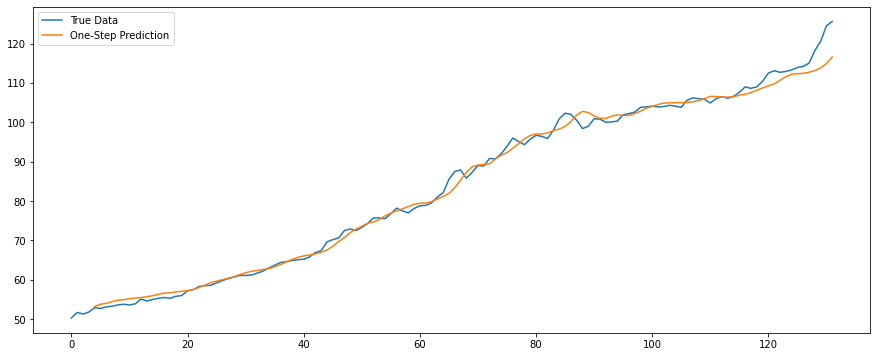

Training Data MSE: 1.75
Test Data MSE: 42.29


In [42]:
# getting results
allPredict = model_lstm.predict(np.reshape(Xall, (Xall.shape[0],time_window,1)))

#Transforming to original scale
allPredict_original_scale = scaler.inverse_transform(allPredict)

allPredictPlot_lstm = np.empty_like(data_scaled)
allPredictPlot_lstm[:, :] = np.nan
allPredictPlot_lstm[time_window:, :] = allPredict_original_scale

# Plot true and in-sample forecast values
plt.figure(figsize=(15,6))
plt.plot(scaler.inverse_transform(data_scaled), label='True Data')
plt.plot(allPredictPlot_lstm, label='One-Step Prediction')
plt.legend()
plt.show()


# Checking training and test score
trainScore = mean_squared_error(Yall_not_scaled[:train_size], allPredict_original_scale[:train_size,0])
testScore = mean_squared_error(Yall_not_scaled[train_size:], allPredict_original_scale[train_size:,0])

print('Training Data MSE: {0:.2f}'.format(trainScore))
print('Test Data MSE: {0:.2f}'.format(testScore))

### Defining Best Performing model based on Test (Out of Sample) Error 

In [43]:
# basic length testing before computing out of sample errors

if len(y_forecast_trend) == len(y_forecast_damped_trend) == \
len(y_forecast_ARIMA) == len(trend_linear_test) == len(Predict_out) == len(allPredict_original_scale[train_size:,0]):
    print(True)
else:
    print('there is a difference in the length')

True


In [44]:
# function for MSE calculation

def test_error(y_test, y_pred):
    
    if isinstance(y_pred, pd.Series) == True:
        error = sum((y_test - y_pred)**2)/len(y_test)
    
    elif isinstance(y_test, np.ndarray) == True:
        error = sum((pd.Series(y_test) - y_pred)**2)/len(y_test)
    
    else:
        error = sum((y_test.values - pd.Series(y_pred.ravel()))**2)/len(y_test)
        
    return error 

In [45]:
# Store errors in a dictionary
errors = {
    'TCES': test_error(df_out['CPI'], y_forecast_trend),
    'Damped_TCES': test_error(df_out['CPI'], y_forecast_damped_trend),
    'ARIMA': test_error(df_out['CPI'], y_forecast_ARIMA),
    'Linear_Regression': test_error(df_out['CPI'], trend_linear_test),
    'FNN': test_error(Yall_not_scaled[train_size:], allPredictPlot[train_size:,0]),
    'LSTM': test_error(Yall_not_scaled[train_size:], allPredict_original_scale[train_size:,0])
}

# Find the model with the minimum error
min_model = min(errors, key=errors.get)
min_error = errors[min_model]

print(f'Model with lowest out-of-sample error: {min_model} with error {min_error}')

Model with lowest out-of-sample error: FNN with error 11.250787841090144


In [46]:
df_test_errors = pd.DataFrame()

df_test_errors['models'] = errors.keys()
df_test_errors['test_errors'] = errors.values()
df_test_errors = df_test_errors.sort_values(by='test_errors')

df_test_errors

,models,test_errors
4,FNN,11.250788
3,Linear_Regression,12.779675
0,TCES,28.196130
2,ARIMA,31.166548
1,Damped_TCES,34.963572
5,LSTM,42.288247


### Refitting with all available data and predict for unseen future 6 quarters

#### Linear Regression

In [47]:
# Refitting Linear Regression
X_full = np.linspace(1, len(df), len(df)) # Create time indexes from 1 to T as the input
X_full = np.reshape(X_full, (len(df), 1))                       # Transform X to 2D array (matrix)
y_full = df.values    

# Create a LinearRegression object
lm = LinearRegression()   

# Train the linear regression model on training data (X,y)
lm.fit(X_full, y_full)

# Forecast the trend component for upcoming 6 unseen quarters
prediction_list = []

for i in range(1, 7):
    trend_forecast = lm.predict(np.array([[len(df)+i]]))
    prediction_list.append(trend_forecast[0])

Y_forecast = prediction_list

#### TCES and damped TCES

In [48]:
# Damped TCES
damped_tces_full = ExponentialSmoothing(df, damped_trend = True, trend='add').fit()
# TCES
tces_full = ExponentialSmoothing(df, damped_trend = False, trend='add').fit() 

y_forecast_tces_full = tces_full.forecast(6)
y_forecast_damped_tces_full = damped_tces_full.forecast(6)

#### ARIMA

In [49]:
# refitting with all current data
model_AIC = ARIMA(df, order=(p, d, q))
results_AIC_ARIMA = model_AIC.fit()

# get fitted values
fitted_AIC = results_AIC_ARIMA.predict()

# get 6 unobserved forecasts
y_forecast_arima = results_AIC_ARIMA.predict(start = len(df), end = len(df)+6-1 )

#### FNN

In [50]:
# select first "window" values to start. In this case, it is 4
window = 4

predictions_fnn = np.array([])

current_input = np.ravel(Xall)[-window:]

# Predict the next 6 unforeseen values
for _ in range(6):
    
    current_input_reshaped = current_input.reshape(1, -1)

    next_value = model_fnn.predict(current_input_reshaped)  
    predictions_fnn = np.append(predictions_fnn, next_value)
    
    current_input = np.append(current_input, next_value)  

    current_input = current_input[-4:] 


fnn_forecast = scaler.inverse_transform(predictions_fnn.reshape(1,-1)).reshape(6,1)
fnn_forecast

1/1 [==============================] - 0s 40ms/step


array([[122.02038379],
       [123.50739989],
       [123.96924739],
       [124.16806259],
       [124.80781493],
       [125.21866784]])

#### LSTM

In [51]:
# select first "window" values to start. In this case, it is 4

predictions_lstm = []

current_input = np.ravel(Xall)[-window:]

# Predict the next 6 unforeseen values
for _ in range(6):
    
    current_input_reshaped = current_input.reshape(1, window, 1)

    next_value = model_lstm.predict(current_input_reshaped)  
    
    #predictions_lstm = np.append(predictions, next_value)
    
    predictions_lstm.append(next_value[0][0])
    
    current_input = np.append(current_input, next_value)  
    
    current_input = current_input[-4:] 


lstm_forecast = scaler.inverse_transform(np.array(predictions_lstm).reshape(1,-1)).reshape(6,1)
lstm_forecast

1/1 [==============================] - 0s 24ms/step


array([[116.60843],
       [117.73491],
       [117.87957],
       [117.31851],
       [115.67773],
       [115.70496]], dtype=float32)

#### Forming Results Data Frame

In [52]:
# Starting date
start_date = date(2023, 3, 1)

# Number of dates to generate
h = 6

# Generate the sequence of dates with a 3-month interval
date_sequence = [start_date + relativedelta(months=3*i) for i in range(h)]

# Print the dates
for d in date_sequence:
    print(d)

2023-03-01
2023-06-01
2023-09-01
2023-12-01
2024-03-01
2024-06-01


In [53]:
df_forecast = pd.DataFrame([None] * h, index = date_sequence,
                           columns = ['Linear_Regression_predicted'])

df_forecast['Linear_Regression_predicted'] = np.array(Y_forecast).ravel().tolist()
df_forecast['FNN_predicted'] = fnn_forecast.ravel()
df_forecast['LSTM_predicted'] = lstm_forecast.ravel()
df_forecast['ARIMA_predicted'] = y_forecast_arima.values
df_forecast['TCES'] = y_forecast_tces_full
df_forecast['Damped TCES'] = y_forecast_damped_tces_full

In [54]:
df_forecast #I will add TCES + SES

,Linear_Regression_predicted,FNN_predicted,LSTM_predicted,ARIMA_predicted,TCES,Damped TCES
2023-03-01,120.758744,122.020384,116.608429,125.552796,126.174800,126.627893
2023-06-01,121.317009,123.507400,117.734909,125.829869,126.749600,127.650646
2023-09-01,121.875275,123.969247,117.879570,126.500706,127.324399,128.668285
2023-12-01,122.433540,124.168063,117.318512,127.219248,127.899199,129.680837
2024-03-01,122.991806,124.807815,115.677727,127.854480,128.473999,130.688325
2024-06-01,123.550071,125.218668,115.704964,128.450147,129.048799,131.690776


In [55]:
#based on least test error above, FNN is the best followed by Linear Regression. 
#This last table reflects 6 unforeseen forecast for each model

### Final Model Forecasts (6 values)

In [56]:
df_forecast[[f'{min_model}_predicted']] #to_csv(f'{min_model}_6_forecasts.csv')

,FNN_predicted
2023-03-01,122.020384
2023-06-01,123.507400
2023-09-01,123.969247
2023-12-01,124.168063
2024-03-01,124.807815
2024-06-01,125.218668
